<a href="https://colab.research.google.com/github/davidgonmar/miscellanea/blob/main/A%20Spectral%20Condition%20for%20Feature%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: https://arxiv.org/pdf/2310.17813

In page 5, they use random matrix theory results to claim
$$
\|W_l h_{l - 1}(x) \|_2 = \|h(x)_{l - 1} \|_2 \sigma_l \sqrt{(n_l)}
$$
when $W_l$ is a Gaussian matrix with mean 0 and standard deviation $\sigma_l$.

In [6]:
import numpy as np

def ratios(m, n, sigma, trials=50, seed=0):
    rng = np.random.default_rng(seed)
    h = rng.normal(size=n)
    lhs_ratios = []
    for _ in range(trials):
        W = rng.normal(0, sigma, size=(m, n))
        lhs = np.linalg.norm(W @ h)
        lhs_ratios.append(lhs / (np.linalg.norm(h) * sigma * np.sqrt(m)))
    return np.mean(lhs_ratios)

for m, n in [(512,256),(1024,512)]:
    for sigma in [0.5,1.0]:
        lhs = ratios(m,n,sigma)
        print(f"m={m} n={n} sigma={sigma} lhs_ratio≈{lhs:.3f}")

m=512 n=256 sigma=0.5 lhs_ratio≈0.991
m=512 n=256 sigma=1.0 lhs_ratio≈0.991
m=1024 n=512 sigma=0.5 lhs_ratio≈0.998
m=1024 n=512 sigma=1.0 lhs_ratio≈0.998


Does it hold during the training of a simple NN?

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"


class MLP(nn.Module):
    def __init__(self, d_in=784, d_hid=512, d_out=10, sigma=1.0):
        super().__init__()
        self.fc1 = nn.Linear(d_in, d_hid, bias=False)
        self.fc2 = nn.Linear(d_hid, d_out, bias=False)
        nn.init.normal_(self.fc1.weight, mean=0.0, std=sigma)
        nn.init.normal_(self.fc2.weight, mean=0.0, std=sigma)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        h1 = self.fc1(x)
        out = self.fc2(h1)
        return out, [x, h1]


model = MLP().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor()),
    batch_size=256,
    shuffle=True,
)

ratios_log = {"fc1_lhs": [], "fc2_lhs": []}

epochs = 100
for epoch in range(epochs):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        out, _ = model(x)
        loss = F.cross_entropy(out, y)
        loss.backward()
        opt.step()

    x, _ = next(iter(train_loader))
    x = x.to(device)
    _, acts = model(x)
    with torch.no_grad():
        fc1_W = model.fc1.weight.data
        fc2_W = model.fc2.weight.data
        h0 = acts[0].detach()
        h1 = acts[1].detach()
        m1, _ = fc1_W.shape
        m2, _ = fc2_W.shape
        s1 = torch.std(fc1_W)
        s2 = torch.std(fc2_W)
        lhs1 = torch.norm(torch.nn.functional.linear(h0, fc1_W), dim=1)
        lhs2 = torch.norm(torch.nn.functional.linear(h1, fc2_W), dim=1)
        r1 = (lhs1 / (torch.norm(h0, dim=1) * s1 * np.sqrt(m1) + 1e-12)).mean().item()
        r2 = (lhs2 / (torch.norm(h1, dim=1) * s2 * np.sqrt(m2) + 1e-12)).mean().item()
        ratios_log["fc1_lhs"].append(r1)
        ratios_log["fc2_lhs"].append(r2)
        print(r1, r2)


1.0092391967773438 0.9014762043952942
1.0102431774139404 0.9206674098968506
1.01201593875885 0.927358865737915
1.008225917816162 0.89715975522995
1.0069477558135986 0.8878639936447144
1.0062158107757568 0.8617318868637085
1.002958059310913 0.838976263999939
1.0076419115066528 0.8372429609298706
1.0020334720611572 0.7908152937889099
1.0044951438903809 0.7720245718955994
1.0029324293136597 0.7351745367050171
1.002328634262085 0.7203543782234192
1.0035643577575684 0.7211803197860718
0.9995548129081726 0.6772832274436951
1.0007262229919434 0.6834693551063538
0.9985594153404236 0.6510213613510132
1.0011565685272217 0.6666761636734009
0.9989109039306641 0.6529135704040527
0.9981926083564758 0.6267523765563965
0.9969613552093506 0.6096571683883667
0.9951040744781494 0.5803329348564148
0.9962152242660522 0.587618887424469
0.998271107673645 0.5767865180969238
0.9934729337692261 0.5927804708480835
0.9940436482429504 0.5878245830535889
0.9899703860282898 0.5994803309440613
0.9890213012695312 0.55

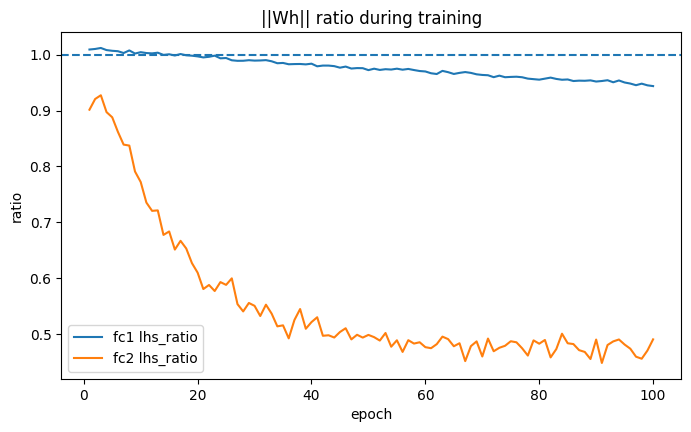

In [25]:
e = np.arange(1, len(ratios_log["fc1_lhs"]) + 1)
plt.figure(figsize=(8, 4.5))
plt.plot(e, ratios_log["fc1_lhs"], label="fc1 lhs_ratio")
plt.plot(e, ratios_log["fc2_lhs"], label="fc2 lhs_ratio")
plt.axhline(1.0, linestyle="--")
plt.xlabel("epoch")
plt.ylabel("ratio")
plt.legend()
plt.title("||Wh|| ratio during training")
plt.show()